In [9]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [28]:
# AlexSánchez codes
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [3]:
train = pd.read_csv('~/source/Data/toxic_comment/train.csv')
test = pd.read_csv('~/source/Data/toxic_comment/test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [5]:
train['comment_text'][0]

"Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated."

In [6]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.34186393464859, 595.10207169971216, 5000)

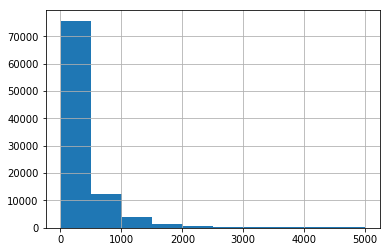

In [10]:
lens.hist();

In [52]:
# no label
len(train) - train.iloc[:, 2:8].max(axis = 1).sum()

86061

In [53]:
# how many label
train.iloc[:, 2:8].sum(axis = 1).unique()

array([1, 0, 3, 2, 4, 5, 6])

In [24]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [25]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [26]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [27]:
trn_term_doc, test_term_doc

(<95851x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 10463449 stored elements in Compressed Sparse Row format>,
 <226998x285100 sparse matrix of type '<class 'numpy.float64'>'
 	with 26144415 stored elements in Compressed Sparse Row format>)

In [29]:
x = trn_term_doc
test_x = test_term_doc

In [43]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
preds = np.zeros((len(test), len(label_cols)))
for i, col in enumerate(label_cols):
    clf = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
    clf.fit(x, train[col])
    preds[:, i] = clf.predict_proba(test_x)[:, 1]

/anaconda/envs/myenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [44]:
sub = pd.DataFrame({'id': test["id"]})
sub = pd.concat([sub, pd.DataFrame(preds, columns = label_cols)], axis=1)

In [45]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.005677,0.000518,0.002279,0.000129,0.002221,0.000532
1,6102620,0.003165,0.000214,0.002768,0.000107,0.001442,0.000403
2,14563293,0.001239,0.000355,0.001457,0.000117,0.001352,0.000239
3,21086297,0.018860,0.001049,0.005513,0.000156,0.004371,0.000299
4,22982444,0.004627,0.000809,0.002852,0.000140,0.001541,0.000647


In [46]:
sub.to_csv('test_0101_2018.csv', index=False)